# Topic Modeling using Latent Dirichlet Allocation (LDA)

The Vox News corpus is a collection of all Vox articles published before March 21, 2017. Vox Media released this dataset as part of the KDD 2017 Workshop on Data Science + Journalism. Their goal for publishing this dataset was to enable data science researchers to apply various techniques on a news dataset.

<b>The dataset consists of 22,994 news articles with their titles, author names, categories, published dates, updated on dates, links to the articles and their short descriptions (8 columns). While visualizing the dataset, I noticed that all the articles are clustered by 185 distinct categories. Out of those articles, 7145 articles were tageed by the category "The Latest". It cannot be a coincidence that such a large number of articles would be tagged by a generic category. Hence, I decided to address this problem by unsupervised learning because the categories of articles cannot be predicted beforehand neither the articles can be tagged by their categories in the training dataset.</b>

<b>We get a crude idea of the article by just skimming through the category of the article. Hence, topic modeling is useful for categorizing or ranking articles which are remaining to be read by an individual. Moreover, clustering of articles based on topics also enable them to be organized by groups of similar topics inside a database. This simplifies the collective analysis of such Big Data especially in the field of News and Journalism where an enormous amount of data is archived and retrieved only when needed. Categorical clustering will also make information retrieval quicker and more efficient.</b>

We can analyze the title, short description and the body of these 7145 articles and predict their categories by using Topic Modeling.

In reality, analyzing the body would drastically improve the topic model. However, due to time constraints and proclivity towards minimalism, I have decided to drop the body column entirely. Also, parsing html tags in the body of articles would be a time-consuming task in itself.

In machine learning and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear equally in both. A document typically concerns multiple topics in different proportions; thus, in a document that is 10% about cats and 90% about dogs, there would probably be about 9 times more dog words than cat words. The "topics" produced by topic modeling techniques are clusters of similar words. A topic model captures this intuition in a mathematical framework, which allows examining a set of documents and discovering, based on the statistics of the words in each, what the topics might be and what each document's balance of topics is.

Topic models are also referred to as probabilistic topic models as they are based on probabilistic graphical modeling, which refers to statistical algorithms for discovering the latent semantic structures of an extensive text body. In the age of information, the amount of the written material we encounter each day is simply beyond our processing capacity. Topic models can help to organize and offer insights for us to understand large collections of unstructured text bodies. Originally developed as a text-mining tool, topic models have been used to detect instructive structures in data such as genetic information, images, and networks. They also have applications in other fields such as bioinformatics. [Source: https://en.wikipedia.org/wiki/Topic_model]

The necessary python libraries and packages like numpy, pandas, matplotlib and scikit-learn have been imported

In [1]:
%matplotlib inline
import pickle
from pprint import pprint
import random
import warnings
import time

# numpy, pandas, matplotlib and regular expressions (data science essentials)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# tqdm
from tqdm import tqdm

# spacy
import spacy
from spacy.lang.en import English
import en_core_web_sm

# gensim
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

# nltk
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import words
from nltk.stem.wordnet import WordNetLemmatizer

# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim

# styling
pd.set_option('display.max_columns',150)
plt.style.use('bmh')
from IPython.display import display

### 1)  Data Visualization

This bubble chart quantifies the number of articles written by different authors.  [Source: https://data.world/elenadata/vox-articles]

![Figure 1](../bin/resources/img/articles-per-author.png "Figure 1")

This graph signifies the gradual increase in the number of articles being published during each month. However, the average articles published in the months of 2017 and 2016 seems to be the similar.  [Source: https://data.world/elenadata/vox-articles]

![Figure 2](../bin/resources/img/articles-by-month.png "Figure 2")

The entire dataset consists of a total of 185 distinct topics. This bubble plot shows records grouped by category. We can observe that the category "The Latest" has the maximum number of records.

![Figure 3](../bin/resources/img/records-by-category.png "Figure 3")

This bar graph tells us the distribution of records around topics and also around different authors who have written about the same topic

![Figure 4](../bin/resources/img/records-by-category-&-author.png "Figure 4")

There are a number of algorithms developed for topic modeling which use singular value decomposition (SVD) and the method of moments. These algorithms are listed below:
<ul>Explicit semantic analysis</ul>
<ul>Latent semantic analysis</ul>
<ul>Latent Dirichlet Allocation (LDA)</ul>
<ul>Hierarchical Dirichlet process</ul>
<ul>Non-Negative Matrix Factorization (NMF)</ul>

I decided to use LDA as it is widely praised topic modeling technique by researchers and data scientists. Owing to my Data Mining project, I also had prior experience on working with Gensim library in Python which has a robust LDA model. LDA is a kind of probabilistic model that exploits similarity between data and extracts inference from the resulting analysis.

In natural language processing, Latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's creation is attributable to one of the document's topics. LDA is an example of a topic model and was first presented as a graphical model for topic discovery by David Blei, Andrew Ng, and Michael I. Jordan in 2003. Essentially the same model was also proposed independently by J. K. Pritchard, M. Stephens, and P. Donnelly in the study of population genetics in 2000. Both papers have been highly influential, with 19858 and 20416 citations respectively by August 2017.  [Source: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation]

In simple words, one can say that LDA converts a set of documents into a set of topics

This cell will auto-download the required NLTK modules

In [2]:
warnings.simplefilter('ignore')

nltk.download('wordnet')
nltk.download('stopwords')

nlp = spacy.load('en')
# nlp = en_core_web_sm.load()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tanveershaikh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tanveershaikh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using NLTK, I am creating a corpus of English words and also an object of the lemmatizer is being created using WordNet

In [3]:
# Initialization and Global Variables
dictionary = dict.fromkeys(words.words(), None)
lemmatizer = WordNetLemmatizer()

# List for filtering out stop words
en_stop = set(nltk.corpus.stopwords.words('english'))

### 2) Reading the dataset (dsjVoxArticles.tsv) - Data Extraction

News Article topic modeling is an unsupervised machine learning method that helps us discover hidden semantic structures in an article, that allows us to learn topic representations of articles in a corpus.

The data is being fetched from the data.world URL and converted into a Pandas DataFrame in the following cell

In [4]:
print("Loading Data...")

url = "https://query.data.world/s/ee6arp6cngynnoj4hvyuhckn3tb4hj"
df = pd.read_csv(url, delimiter = '\t', encoding = 'utf-8')

Loading Data...


Selecting only the articles having category as 'The Latest' and dropping all other articles which have their correct categories would be unfair because we are dropping our training data. Hence, I am keeping all 22,994 rows

### 3) Exploratory Analysis

This section deals with exploring and analyzing the dataset. It will give us a deeper understanding of the dataset by making us familiar with all the rows and columns of the dataset.

In [5]:
# Prints out the first 5 rows of data in the dataset
df.head()

,title,author,category,published_date,updated_on,slug,blurb,body
0,Bitcoin is down 60 percent this year. Here's w...,Timothy B. Lee,Business & Finance,2014-03-31 14:01:30,2014-12-16 16:37:36,http://www.vox.com/2014/3/31/5557170/bitcoin-b...,Bitcoins have lost more than 60 percent of the...,<p>The markets haven't been kind to<span> </sp...
1,6 health problems marijuana could treat better...,German Lopez,War on Drugs,2014-03-31 15:44:21,2014-11-17 00:20:33,http://www.vox.com/2014/3/31/5557700/six-probl...,Medical marijuana could fill gaps that current...,<p>Twenty states have so far legalized the med...
2,9 charts that explain the history of global we...,Matthew Yglesias,Business & Finance,2014-04-10 13:30:01,2014-12-16 15:47:02,http://www.vox.com/2014/4/10/5561608/9-charts-...,These nine charts from Thomas Piketty's new bo...,<p>Thomas Piketty's book <i>Capital in the 21s...
3,Remember when legal marijuana was going to sen...,German Lopez,Criminal Justice,2014-04-03 23:25:55,2014-05-06 21:58:42,http://www.vox.com/2014/4/3/5563134/marijuana-...,"Three months after legalizing marijuana, Denve...",<p><span>When Colorado legalized recreational ...
4,Obamacare succeeded for one simple reason: it'...,Sarah Kliff,Health Care,2014-04-01 20:26:14,2014-11-18 15:09:14,http://www.vox.com/2014/4/1/5570780/the-two-re...,"After a catastrophic launch, Obamacare still s...",<p>There's a very simple reason that Obamacare...


In [6]:
# Prints out the last 5 rows of data in the dataset
df.tail()

,title,author,category,published_date,updated_on,slug,blurb,body
23019,Marijuana legalization opponents warned teen p...,German Lopez,The Latest,2017-03-21 19:30:01,2017-03-21 19:51:00,http://www.vox.com/policy-and-politics/2017/3/...,,"<p id=""6OljE3"">So far, <a href=""http://www.vox..."
23020,4 ways the House health care vote could go dow...,Andrew Prokop,The Latest,2017-03-21 21:41:12,2017-03-21 23:46:25,http://www.vox.com/policy-and-politics/2017/3/...,This Thursday should be an eventful day.,"<p id=""5WuiOu"">House Speaker Paul Ryan still a..."
23021,In search of Forrest Fenn's treasure,Zachary Crockett,First Person,2017-02-28 12:33:27,2017-02-28 14:12:31,http://www.vox.com/a/fenn-treasure-hunt-map,,"<div class=""restricted""> \n \n <p class=..."
23022,Oscars 2017: every movie nominated for an Acad...,Sarah Frostenson,The Latest,2017-02-23 20:20:01,2017-02-26 14:10:56,http://www.vox.com/a/oscars-2017-movies-nominees,"Yes, even 13 Hours: The Secret Soldiers of Ben...","<h2 id=""RCAyzl""><a href=""http://www.imdb.com/..."
23023,Transcript: President Trumpâ€™s speech to Cong...,Vox Staff,Congress,2017-03-01 01:06:07,2017-03-01 04:06:34,http://www.vox.com/a/trump-speech-transcript-j...,,<p>President Trump took a trip up Pennsylvani...


In [7]:
# Summary statistics about the data column-wise
df.describe()

,title,author,category,published_date,updated_on,slug,blurb,body
count,23024,23023,23013,23013,23013,23013,23013,23013
unique,22977,825,185,22825,22474,23013,20043,23013
top,"Republican debate 2016 live stream: time, TV s...",German Lopez,The Latest,2016-07-13 12:00:03,2016-11-16 21:01:35,http://www.vox.com/xpress/2014/11/19/7248249/n...,,<p>Pussy Riot released its first song in Engli...
freq,7,2243,7152,9,24,1,2729,1


### 4) Data Pre-Processing

#### Split Training and Testing sets

In [8]:
print("Splitting Data...")

# Training set with all 20003 rows
df_train = df.copy()

# Duplicate the original dataset
df_test = df.copy()

# Drop rows with category "The Latest" from our training dataset
df_train = df_train.loc[df_train['category'] != 'The Latest']

Splitting Data...


Initially, the data pre-processing steps include dropping the irrelevant columns from the dataframe and then dropping the rows having any of the values as NaN.

But before doing that step, empty cell locations are being checked or the ones having whitespaces. These rows are marked and dropped entirely.

In [9]:
print("Cleaning the dataset...")

columns_train = ['author','category','published_date','updated_on','slug','body']
df_train.drop(columns_train, axis = 1, inplace = True)

columns_test = ['author','published_date','updated_on','slug','body']
df_test.drop(columns_test, axis = 1, inplace = True)

Cleaning the dataset...


In [10]:
print(df.shape)
print(df.ndim)

(23024, 8)
2


I decided to drop missing values as we have a large number of records to train on and the number of records having at least 1 value missing is negligible. Hence, it will only have minuscule effect on our model’s performance which can be neglected. <br>

<br>I am deleting the author, published_date and updated_on columns as they are irrelevant to my end goal, which is, topic modeling using the title and blurb (short description).<br>

<br>I have also decided to delete the slug and body columns as this is just a naive implementation of topic modeling. I will have to consider those two columns after completing this project to make my topic modeling more coherent.
Also, I am dropping the category column as I am trying to determine that attribute itself and unsupervised learning does not require the training labels.


### 5) Feature Selection

In [11]:
print("Removing missing values...")

df_train['blurb'].replace(' ', np.nan, inplace = True)
df_train.dropna(axis = 0, how = 'any', inplace = True)

df_test['blurb'].replace(' ', np.nan, inplace = True)
df_test.dropna(axis = 0, how = 'any', inplace = True)

Removing missing values...


I am performing the operation of cleaning up weird characters from the dataframe. These characters exist because the string data was decoded in another format and is now being encoded in UTF-8 format

In [12]:
print("Removing non-ascii and non-unicode characters...")

df_train.apply(lambda x: x.apply(lambda y: y.strip() if type(y) == type('') else y), axis=0)

df_train['blurb'] = df_train['blurb'].str.replace('â€™',"'").str.replace('â€”',"-").str.replace('â€œ','"').str.replace('â€','"')
df_train['blurb'] = df_train['blurb'].str.strip()
df_train['blurb'] = df_train['blurb'].apply(lambda x: x.strip())

df_train['title'] = df_train['title'].str.replace('â€™',"'").str.replace('â€”',"-").str.replace('â€œ','"').str.replace('â€','"')
df_train['title'] = df_train['title'].str.strip()
df_train['title'] = df_train['title'].apply(lambda x: x.strip())

# Same operation on test dataset
df_test.apply(lambda x: x.apply(lambda y: y.strip() if type(y) == type('') else y), axis=0)

df_test['blurb'] = df_test['blurb'].str.replace('â€™',"'").str.replace('â€”',"-").str.replace('â€œ','"').str.replace('â€','"')
df_test['blurb'] = df_test['blurb'].str.strip()
df_test['blurb'] = df_test['blurb'].apply(lambda x: x.strip())

df_test['title'] = df_test['title'].str.replace('â€™',"'").str.replace('â€”',"-").str.replace('â€œ','"').str.replace('â€','"')
df_test['title'] = df_test['title'].str.strip()
df_test['title'] = df_test['title'].apply(lambda x: x.strip())

# Checking Values
print("Checking values...")
# print(df_train.at[23003, 'blurb'])

Removing non-ascii and non-unicode characters...
Checking values...


Here, I am keeping only the distinct (unique) values of titles as well as of the blurb and dropping duplicates

In [13]:
print("Removing Duplicates...")

df_train = df_train.drop_duplicates('blurb')
df_train = df_train.drop_duplicates('title')

df_test = df_test.drop_duplicates('blurb')
df_test = df_test.drop_duplicates('title')

Removing Duplicates...


Converting our dataset into a collection of 5495 documents with just 1 column consisting of title concatenated with blurb.

In [14]:
print("Creating Training and Test Sets...")

df_train['documents'] = df_train['title'].map(str) + '. ' + df_train['blurb'].map(str)

df_test['documents'] = df_test['title'].map(str) + '. ' + df_test['blurb'].map(str)

Creating Training and Test Sets...


In [15]:
columns = ['title','blurb']
df_train.drop(columns, axis = 1, inplace = True)

df_test.drop(columns, axis = 1, inplace = True)

Selecting only the articles having category as 'The Latest' and dropping all other articles which have their correct categories to build our test set

In [16]:
# Test set with only approximately 5554 articles which have category as "The Latest"
df_test = df_test.loc[df_test['category'] == 'The Latest']
df_test.drop('category', axis = 1, inplace = True)

print(df_train.shape)
print(df_train.ndim)

print(df_test.shape)
print(df_test.ndim)

(14554, 1)
2
(5455, 1)
2


LDA Implementation Process:<br>
<br>The number of topics should have been already decided even if we're not sure what the topics are.
<br>Each document is represented as a distribution over topics.
<br>Each topic is represented as a distribution over words.

### 6) Text Cleaning and Tokenization

The following function cleans our text and returns a list of tokens

In [17]:
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

### 7) Lemmatization

Next, I will use NLTK's Wordnet to find the synonyms, antonyms and the meanings of words. In addition, WordNetLemmatizer() will give us the root word of a token. (similar to stemming but better)

In [18]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

I am trying to make my code modularized by defining functions for specific tasks. 

Like, I defined this function to prepare the text for topic modeling

### 8) Stopwords Removal

In [19]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

### 9) Feature Extraction

The following function opens our data frame, reads each row sequentially; and for each row, prepares text for LDA, and then adds it to a list. This function calls the helper function prepare_text_for_lda(text) which in-turn calls all the other functions I defined above

The following cell shows how each of our document is being tokenized. Each and every document is getting converted into a list of tokens.

In [20]:
print("Document-Term Matrix is being created...")

text_data = []
for row in tqdm(df_train['documents']):
    tokens = prepare_text_for_lda(row)
    #if random.random() > .99:
        #print(tokens)
    text_data.append(tokens)

  0%|          | 0/14554 [00:00<?, ?it/s]

Document-Term Matrix is being created...


100%|██████████| 14554/14554 [00:17<00:00, 812.39it/s]


### 10) Feature Engineering

The word dictionary and corpus needed for topic modeling are created and saved on disk for further usage

#### LDA with Gensim

Firstly, I am creating a dictionary from our data, then I am converting it into a bag-of-words corpus and then saving the dictionary and corpus for future use using pickle library

In [21]:
print("Generating corpus and dictionary...")

dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
pickle.dump(corpus, open('../bin/resources/corpus.pkl', 'wb'))
dictionary.save('../bin/resources/dictionary.gensim')

Generating corpus and dictionary...


### 11) Building the Topic Model (Training)

Now, the number of topics in the articles will be proportional to the number of articles in the dataset. For our original dataset consisting of 22,994 articles, we had around 185 distinct topics. Proportionally, for our subset of articles; it can be inferred that we will have around 42 unique topics. So , the total topics to be trained on becomes 227

However, this is just a rough estimate. The optimal value of the number of topics for LDA will be tuned by considering it as a hyperparameter later.

LDA is finding 227 topics from our data

[UPDATE: After cross-validation and hyper parameter tuning by taking coherence score as a metric, I have concluded that 100 is the accurate value for NUM_TOPICS]

In [22]:
%%time
print("Training LDA model on train dataframe...")

NUM_TOPICS = 100
start_time = time.time()
ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=NUM_TOPICS, 
                                           random_state=89, 
                                           update_every=1,  
                                           id2word=dictionary, 
                                           passes=42, 
                                           alpha='auto', 
                                           per_word_topics=True)

ldamodel.save('../bin/resources/models/model' + str(NUM_TOPICS) + '.gensim')
train_time = time.time() - start_time
print("Training Time --- %s seconds " % (round(train_time, 2)))

Training LDA model on train dataframe...
Training Time --- 151.49 seconds 
CPU times: user 2min 26s, sys: 4.01 s, total: 2min 30s
Wall time: 2min 31s


Here, our coupus is the collection of term vectors for each document. Hence, it is also called as the Document-Term Matrix. Its dimensions are [number of documents x number of words in the dictionary(vocabulary)]

The above LDA model is built with 100 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [23]:
print("Allocated models of each topic...")

topics_train = []
topics = ldamodel.print_topics()
for topic in topics:
    pprint(topic)
    topics_train.append(topic)
    
results_dir = "../output/"
with open(results_dir + "results_train.txt", 'w') as f:
    pprint(topics_train, stream=f)

Allocated models of each topic...
(53,
 '0.127*"book" + 0.060*"baltimore" + 0.052*"county" + 0.052*"dream" + '
 '0.049*"corruption" + 0.044*"influence" + 0.034*"football" + '
 '0.033*"prosecutor" + 0.032*"twist" + 0.029*"louis"')
(90,
 '0.069*"destroy" + 0.069*"summer" + 0.060*"normal" + 0.056*"heart" + '
 '0.040*"especially" + 0.039*"equal" + 0.038*"paragraph" + 0.036*"current" + '
 '0.033*"solution" + 0.028*"smith"')
(82,
 '0.113*"street" + 0.054*"funny" + 0.050*"martin" + 0.041*"survive" + '
 '0.038*"outside" + 0.035*"buying" + 0.034*"easily" + 0.033*"bill" + '
 '0.031*"declare" + 0.028*"harry"')
(8,
 '0.073*"oscar" + 0.070*"poverty" + 0.055*"hear" + 0.041*"track" + '
 '0.039*"pattern" + 0.039*"showing" + 0.032*"spy" + 0.031*"collapse" + '
 '0.030*"discus" + 0.027*"document"')
(27,
 '0.107*"words" + 0.076*"border" + 0.045*"germany" + 0.043*"replace" + '
 '0.038*"skeptical" + 0.035*"mostly" + 0.031*"mental" + 0.028*"turning" + '
 '0.028*"explain" + 0.026*"judges"')
(56,
 '0.124*"fail

Topic 53 is represented as '0.127*"book" + 0.060*"baltimore" + 0.052*"county" + 0.052*"dream" + 0.049*"corruption" + 0.044*"influence" + 0.034*"football" + 0.033*"prosecutor" + 0.032*"twist" + 0.029*"louis"'

It means the top 10 keywords that contribute to this topic are: ‘book’, ‘baltimore’, ‘county’.. and so on and the weight of ‘book’ on topic 53 is 0.127.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be. You may summarise it either as ‘country lifestyle’ or ‘village’.

Likewise, can you go through the remaining topic keywords and judge what the topic is.

Topic 5 includes words like “america”, "problem", "family", "ignore" and "crisis" which sounds like a topic related to national issues.

Topic 66 includes words like “obama”, “president”, “immigrant” and "george"; it is definitely a politics related topic.

Topic 53 includes words like “book”, “baltimore”, “county”, "louis" and “dream”, sounds like a topic related to country lifestyle. and so on.

With LDA, we can see that different documents have different topics, and the discriminations are obvious.

### 12) Model Evaluation

#### Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. Topic coherence score can be good metric to find out an optimum value of number of topics

In [24]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -22.932056122598887

Coherence Score:  0.5751547973447124


### 13) Testing Results

In [25]:
print("Testing LDA model on test dataframe...")

doc_bow = []
doc_topics = []
for row in tqdm(df_test['documents']):
    row = prepare_text_for_lda(row)
    row_bow = dictionary.doc2bow(row)
    doc_bow.append(row_bow)
    doc_topics.append(ldamodel.get_document_topics(row_bow))

  1%|          | 51/5455 [00:00<00:10, 506.19it/s]

Testing LDA model on test dataframe...


100%|██████████| 5455/5455 [00:08<00:00, 614.92it/s]


In [26]:
# Write test results to results_test.txt file

results_dir = "../output/"
with open(results_dir + "results_test.txt", 'w') as f:
    pprint(doc_bow, stream=f)
    pprint(doc_topics, stream=f)

In [27]:
print("Example Test Result:")

for i in df_test['documents'].head():
    print(i)
    print("")

Example Test Result:
Obama wants to fight gerrymandering once he leaves office. He should look to Canada for advice.. Our neighbor to the north solved its gerrymandering problem decades ago.

4/20: National Weed Day, explained. Tens of thousands are celebrating a less traditional holiday this year: 4/20.

You're Shakespeare, but you're playing Hamlet as well: Gregory Rabassa on translation. Gregory Rabassa, who died Tuesday, is probably the reason you've been able to read the works of Gabriel Garcia Marquez or Julio Cortazar.

This awesome footage of DC was shot by an illegal drone. And the troubling things it tells us about the future of surveillance.

A viewer's guide to the 2016 National Spelling Bee. What you need to know before the carnage begins.



In [28]:
# One test example

for i in df_test['documents'].head(1):
    i = prepare_text_for_lda(i)
    i_bow = dictionary.doc2bow(i)
    pprint(i_bow)
    pprint(ldamodel.get_document_topics(i_bow))

[(16, 1),
 (61, 1),
 (72, 1),
 (444, 1),
 (764, 1),
 (807, 1),
 (842, 1),
 (893, 2),
 (1159, 1),
 (1291, 1),
 (2736, 1),
 (3147, 1),
 (4633, 1)]
[(5, 0.05418119),
 (15, 0.050385818),
 (19, 0.012430273),
 (40, 0.051636316),
 (43, 0.04971525),
 (47, 0.051188823),
 (49, 0.05030443),
 (55, 0.050453342),
 (60, 0.098708674),
 (66, 0.054648157),
 (74, 0.050949663),
 (83, 0.053952634),
 (84, 0.052151565),
 (89, 0.052355338)]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example; (444, 1) above implies, word id 444 occurs once in the first document. Likewise, word id 893 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [29]:
dictionary[893]

'gerrymander'

Our LDA model is making predictions about the first sentence (document) in the output of head(). We can read the sentence and infer that the document is about politics. The LDA output shows that topic 60 has the highest probability assigned, and topic 66 has the second highest probability assigned.

We can look at our LDA model's frequent keywords output for topic 60. They are about politics. Therefore, we can confirm that our model works!

The factors corresponding to each component (topic) should add up to 1. That’s not a coincidence. Indeed, LDA considers documents as being generated by a mixture of the topics. The purpose of LDA is to compute how much of the document was generated by which topic.

Also the sum of all the probabilities of a document belonging to each and every class should also be 1.

LDA is an iterative algorithm. Here are the two main steps:
<ol>
    <li>In the initialization stage, each word is assigned to a random topic.</li>
    <li>Iteratively, the algorithm goes through each word and reassigns the word to a topic taking into consideration:</li>
    <ol>&bull; What’s the probability of the word belonging to a topic</ol>
    <ol>&bull; What’s the probability of the document to be generated by a topic</ol>
</ol>
</ol>
[Source: https://nlpforhackers.io/topic-modeling/]

### 14) Cross-Validation

#### Optimal value for number of topics

I ran the LDA model for different values of number_of_topics and recorded their coherence scores. The data collected is represented in a tabular form below:

| Number of Topics | Coherence Scores |
|:----------------:|:----------------:|
|        50        |       0.37       |
|        64        |       0.52       |
|        70        |       0.53       |
|        80        |       0.54       |
|        90        |       0.56       |
|        100       |       0.57       |
|        101       |       0.57       |
|        102       |       0.569      |
|        103       |       0.569      |
|        104       |       0.568      |
|        109       |       0.567      |
|        117       |       0.566      |
|        123       |       0.564      |
|        137       |       0.561      |
|        165       |       0.54       |
|        227       |       0.523      |

Let us try to plot this data and infer the optimum value of number_of_topics

#### Learning Curves

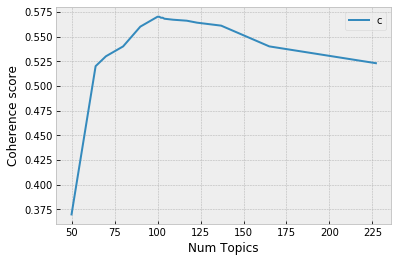

In [30]:
# Show graph
no_of_topics = [50, 64, 70, 80, 90, 100, 101, 102, 103, 104, 109, 117, 123, 137, 165, 227]
coherence_scores = [0.37, 0.52, 0.53, 0.54, 0.56, 0.57, 0.57, 0.569, 0.569, 0.568, 0.567, 0.566, 0.564, 0.561, 0.54, 0.523]
plt.plot(no_of_topics, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

The approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k); where k is a hyperparameter, and pick the one that gives the highest coherence value.

Various LDA models with different number of topics (k) were tested and their coherence scores were plotted; where k is a hyperparameter. We are supposed to choose that k which gives the highest coherence score.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. Picking a higher stable value will lead to overfitting (more variance); whereas, picking a small value will underfit our model (more bias).

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

<b>By observing the graph above, the optimum value of number of topics is chosen to be 100 topics.</b>

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest coherence value before flattening out. This is exactly the case here.

### 15) Visualizing the Topic Keywords

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. The pyLDAvis package’s interactive chart is one of the best tools to visualize LDA model and view each of the topic keywords.

In [31]:
# Enabling pyLDAvis
pyLDAvis.enable_notebook()

In [32]:
# Visualizing our optimal model with 100 topics
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
19     3.218862        1       1  0.050140  0.115418
24     1.974433        1       2 -0.014326 -0.026170
71     1.917595        1       3  0.075535  0.022347
66     1.904046        1       4 -0.004215  0.022603
7      1.795307        1       5  0.237615  0.075366
5      1.734004        1       6 -0.052349  0.207543
70     1.717150        1       7 -0.038809  0.120251
83     1.704457        1       8  0.139723  0.030402
75     1.543775        1       9  0.074781  0.094653
97     1.500852        1      10  0.038917 -0.028453
65     1.490233        1      11  0.155017  0.032624
18     1.447973        1      12 -0.057702  0.118198
9      1.423213        1      13 -0.030103 -0.026578
76     1.329882        1      14 -0.026794 -0.023985
14     1.326406        1      15 -0.053891  0.152726
25     1.291281        1      16 -0.054914  0.090805
84     1.274783        1      17 -0.021021 -0.037238
36     1.274627        1      18  0.176803 -0.009301
89     1.227689        1      19 -0.021054  0.050298
4      1.220265        1      20  0.021689  0.039986
10     1.215711        1      21 -0.014645  0.074811
87     1.198480        1      22 -0.027428 -0.048543
93     1.189220        1      23 -0.024233  0.004749
88     1.183362        1      24 -0.034437  0.116686
73     1.170694        1      25  0.078517 -0.031793
67     1.160714        1      26 -0.032007 -0.031449
32     1.146011        1      27  0.115081  0.090929
31     1.128007        1      28  0.000211  0.040463
50     1.078556        1      29  0.067527 -0.024007
58     1.077427        1      30 -0.042528  0.059363
...         ...      ...     ...       ...       ...
63     0.754437        1      71 -0.036162 -0.046956
15     0.751973        1      72 -0.052666  0.084015
99     0.739827        1      73 -0.061821  0.036625
51     0.739717        1      74 -0.001170  0.045915
39     0.738386        1      75 -0.042131 -0.053551
98     0.723639        1      76 -0.041258 -0.043077
57     0.720966        1      77 -0.045506 -0.064976
28     0.715928        1      78  0.047983 -0.055518
49     0.709606        1      79  0.005110 -0.063854
17     0.685995        1      80 -0.004618  0.016262
68     0.684151        1      81  0.003332 -0.059908
11     0.658696        1      82 -0.042684 -0.071945
72     0.657935        1      83 -0.043260  0.006367
64     0.651862        1      84 -0.002863 -0.028283
95     0.648320        1      85 -0.047600 -0.070764
26     0.634686        1      86 -0.040685 -0.059284
0      0.622229        1      87 -0.052602 -0.038765
61     0.620936        1      88 -0.040792 -0.067833
1      0.613551        1      89 -0.058954  0.009027
59     0.611706        1      90 -0.062835  0.051963
12     0.591394        1      91  0.116037 -0.067085
48     0.567318        1      92  0.060823 -0.069784
43     0.564819        1      93 -0.046046 -0.086750
37     0.550813        1      94 -0.048441 -0.062804
27     0.535226        1      95  0.044020  0.044451
82     0.529618        1      96 -0.009447 -0.053201
90     0.518527        1      97 -0.043623 -0.076678
8      0.509999        1      98 -0.008603 -0.074036
56     0.502029        1      99 -0.045620 -0.068403
53     0.439065        1     100 -0.055733 -0.087918

[100 rows x 5 columns], topic_info=      Category         Freq          Term        Total  loglift  logprob
term                                                                    
2480   Default  4135.000000         trump  4135.000000  30.0000  30.0000
430    Default  1304.000000       clinton  1304.000000  29.0000  29.0000
68     Default  1069.000000    republican  1069.000000  28.0000  28.0000
72     Default  1051.000000         obama  1051.000000  27.0000  27.0000
73     Default   945.000000     president   945.000000  26.0000  26.0000
136    Default   850.000000         state   850.000000  25.0000  25.0000
934    Def

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

After selecting one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

<b>Saliency:</b> a measure of how much the term tells you about the topic.

<b>Relevance:</b> a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic. 

[Source: Wikipedia]

The size of the bubble measures the importance of the topics, relative to the data.

First, we got the most salient terms, means terms mostly tell us about what’s going on relative to the topics. We can also look at individual topic.

In [33]:
pyLDAvis.save_html(vis, '../bin/resources/vis' + str(NUM_TOPICS) + '.html')

In [34]:
# Visualizing 42 topics
dictionary = gensim.corpora.Dictionary.load('../bin/resources/dictionary.gensim')
corpus = pickle.load(open('../bin/resources/corpus.pkl', 'rb'))

lda42 = gensim.models.ldamodel.LdaModel.load('../bin/resources/models/model42.gensim')
lda_display42 = pyLDAvis.gensim.prepare(lda42, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display42)

In [35]:
# Visualizing 23 topics
# lda23 = gensim.models.ldamodel.LdaModel.load('model23.gensim')
# lda_display23 = pyLDAvis.gensim.prepare(lda23, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display23)

# Visualizing 32 topics
# lda32 = gensim.models.ldamodel.LdaModel.load('model32.gensim')
# lda_display32 = pyLDAvis.gensim.prepare(lda32, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display32)

# Visualizing 42 topics
# lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
# lda_display3 = pyLDAvis.gensim.prepare(lda3, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display3)

# Visualizing 64 topics
# lda64 = gensim.models.ldamodel.LdaModel.load('model64.gensim')
# lda_display64 = pyLDAvis.gensim.prepare(lda64, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display64)

# Visualizing 87 topics
# lda87 = gensim.models.ldamodel.LdaModel.load('model87.gensim')
# lda_display87 = pyLDAvis.gensim.prepare(lda87, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display87)

# Visualizing 118 topics
# lda118 = gensim.models.ldamodel.LdaModel.load('model118.gensim')
# lda_display118 = pyLDAvis.gensim.prepare(lda118, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display118)

# Visualizing 143 topics
# lda143 = gensim.models.ldamodel.LdaModel.load('model143.gensim')
# lda_display143 = pyLDAvis.gensim.prepare(lda143, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display143)

# Visualizing 165 topics
# lda165 = gensim.models.ldamodel.LdaModel.load('model165.gensim')
# lda_display165 = pyLDAvis.gensim.prepare(lda165, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display165)

# Visualizing 189 topics
# lda189 = gensim.models.ldamodel.LdaModel.load('model189.gensim')
# lda_display189 = pyLDAvis.gensim.prepare(lda189, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display189)

# Visualizing 210 topics
# lda210 = gensim.models.ldamodel.LdaModel.load('model210.gensim')
# lda_display210 = pyLDAvis.gensim.prepare(lda210, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display210)

# Visualizing 232 topics
# lda232 = gensim.models.ldamodel.LdaModel.load('model232.gensim')
# lda_display232 = pyLDAvis.gensim.prepare(lda232, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display232)

# Visualizing 256 topics
# lda256 = gensim.models.ldamodel.LdaModel.load('model256.gensim')
# lda_display256 = pyLDAvis.gensim.prepare(lda256, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display256)

In [36]:
%%time
warnings.filterwarnings("ignore")
lda = gensim.models.LdaModel.load('../bin/resources/models/model100.gensim')

CPU times: user 22.4 ms, sys: 22.6 ms, total: 45 ms
Wall time: 43.6 ms


#### Bar Graph showing words importance

This graph shows important words for the first 10 topics

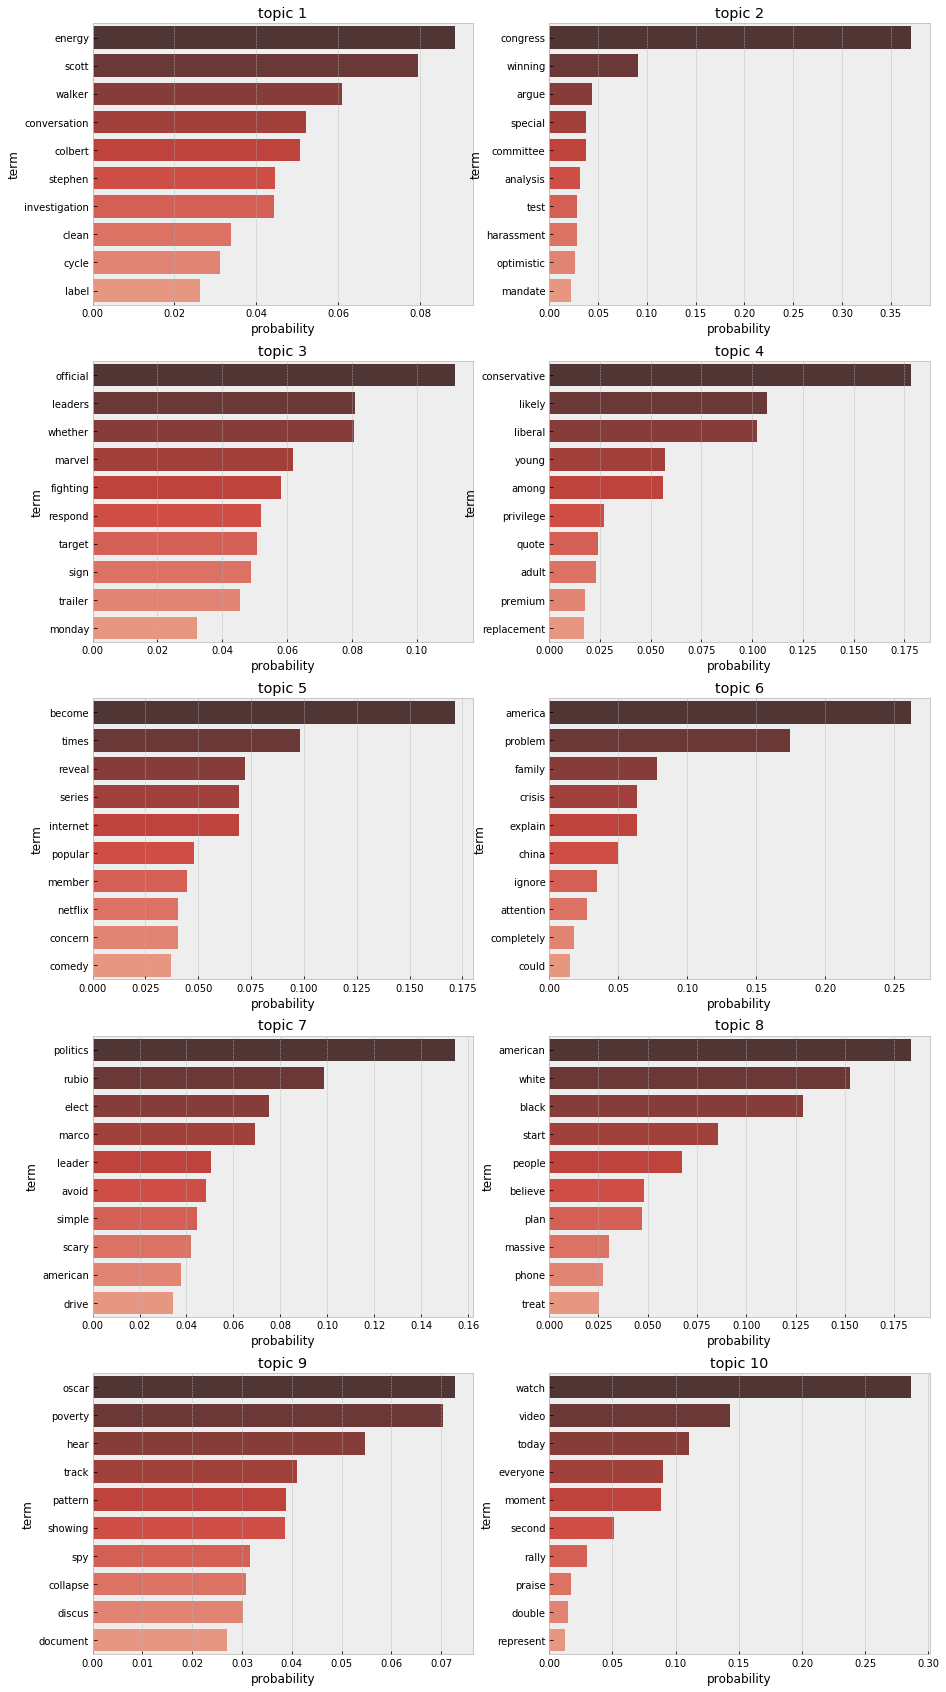

In [37]:
fiz = plt.figure(figsize=(15,30))
for i in range(10):
    df = pd.DataFrame(lda.show_topic(i), columns=['term','prob']).set_index('term')
    # df=df.sort_values('prob')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    plt.xlabel('probability')
    
plt.show()

### Conclusion

We did topic modeling on Vox Articles dataset and derived frequent topic words from a dataset of approximately 15000 news articles published before March 2017. We then tested our model on a separate dataset of around 5000 news articles from current affairs marked as "The Latest". This test dataset was also derived from the same Vox database. We built a basic topic model using Gensim’s LDA and visualized the topics using pyLDAvis. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

LDA can be used for automatic tagging. We can go over each topic and attach a label to it.